# Overview
The purpose of this notebook is to explore relationships between UPC codes and GL Categories for a specific member location using data generated by their store.  From a product perspective, it will be useful to develop a product for members that eliminate the time consuming task of hard-coded rules that may lead to rigid rules necessitating the need to add more and more rules.

While it is not entirely clear at this point whether or not hard-coded rules have good performance in correctly classifying new items that are added to the system in real time (from line items, for example) but what is certain is that the system could benefit from machine learning by (1) applying classifications using a more structured approach to classification and (2) alleviating the lengthy process of new customers to classify individual items.
> N.B. : We could use some more information here about the rules of the system.  See SOW in Jira for more technical detail.

Eventually, location-specific models could be applied by members to other member locations using fixed-effects / hierarchical models or applied to new members in the group (in the spirit of the cooperative).  Members could pay a service fee to LBMX for providing the service on per-member based on estimated operational savings and improved reporting.

# Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
%matplotlib inline

### UPC and Product Descriptions

In [4]:
product_df = pd.read_csv('../data/2018-02-27_UPCDescriptions.csv',sep='\t')
product_df.head()

,UPCCode,Description
0,5645460,BWC MOIST PLUS SHAMP
1,5645460,BWC SHAMP MOISTURE PLUS
2,5645460,MOISTURE PLUS SHAMPOO
3,5645460,"SHAMP,MOISTURE PLUS"
4,5645461,BWC COND MOISTURE PLUS


In [5]:
product_df = product_df.astype('str')

### SQL Features

In [6]:
training_df = pd.read_csv('../data/2018-02-27_GLCategoryTrainingData.csv', sep='\t')
training_df.head()

,UniversalProductCode,AvgUnitsShipped,StdUnitsShipped,MinUnitsShipped,MaxUnitsShipped,AvgNetAmount,StdNetAmount,MinNetAmount,MaxNetAmount,NumberOfTransactions,NumberOfTransactionDays,GLCategory
0,69765869205,1.000000,0.000000,1.0,1.0,37.183750,2.495539,34.92,40.50,8,8,Inventory - Packaged Grocery
1,2250613410,1.145454,0.573699,1.0,6.0,35.645381,8.054258,0.00,76.20,275,174,Inventory - Packaged Grocery
2,85688520009,4.336294,4.418702,0.0,36.0,8.962798,9.049392,0.00,79.56,1576,264,Inventory - Body Care
3,89477300104,1.343834,0.910368,0.0,20.0,19.427881,13.187472,0.00,231.40,3682,290,Inventory - Packaged Grocery
4,25317775304,1.579902,1.617614,-3.0,26.0,72.828589,68.665828,-123.66,1071.72,1531,237,Inventory - Meat


#### Summary

In [7]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7071 entries, 0 to 7070
Data columns (total 12 columns):
UniversalProductCode       7071 non-null int64
AvgUnitsShipped            7071 non-null float64
StdUnitsShipped            7008 non-null float64
MinUnitsShipped            7071 non-null float64
MaxUnitsShipped            7071 non-null float64
AvgNetAmount               7071 non-null float64
StdNetAmount               7008 non-null float64
MinNetAmount               7071 non-null float64
MaxNetAmount               7071 non-null float64
NumberOfTransactions       7071 non-null int64
NumberOfTransactionDays    7071 non-null int64
GLCategory                 7071 non-null object
dtypes: float64(8), int64(3), object(1)
memory usage: 663.0+ KB


7K SKUs, some missing values

In [8]:
training_df.isnull().sum()

UniversalProductCode        0
AvgUnitsShipped             0
StdUnitsShipped            63
MinUnitsShipped             0
MaxUnitsShipped             0
AvgNetAmount                0
StdNetAmount               63
MinNetAmount                0
MaxNetAmount                0
NumberOfTransactions        0
NumberOfTransactionDays     0
GLCategory                  0
dtype: int64

Null standard deviations means there was only one record over which the aggregate values were calculated

#### Categories

In [9]:
training_df.GLCategory.unique()

array(['Inventory - Packaged Grocery', 'Inventory - Body Care',
       'Inventory - Meat', 'Inventory - Refrigerated Grocery',
       'Inventory - Frozen', 'Inventory - Vitamins',
       'Inventory - Packaged Tea'], dtype=object)

Drop the 'Inventory - ' from categories to make it easier to read

In [10]:
training_df['GLCategory'] = training_df.GLCategory.str.replace(r'Inventory - *', '')
training_df.GLCategory.unique()

array(['Packaged Grocery', 'Body Care', 'Meat', 'Refrigerated Grocery',
       'Frozen', 'Vitamins', 'Packaged Tea'], dtype=object)

Update the UPC type

In [11]:
training_df['UniversalProductCode'] = training_df['UniversalProductCode'].astype(str)

Category distributions

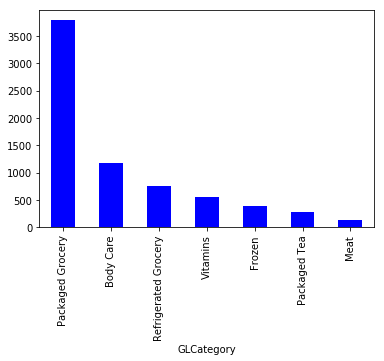

In [12]:
training_df.groupby('GLCategory').size().sort_values(ascending=False).plot(kind='bar', color='blue');

In [13]:
training_df.groupby('GLCategory').size().sort_values(ascending=False)

GLCategory
Packaged Grocery        3783
Body Care               1178
Refrigerated Grocery     754
Vitamins                 563
Frozen                   387
Packaged Tea             279
Meat                     127
dtype: int64

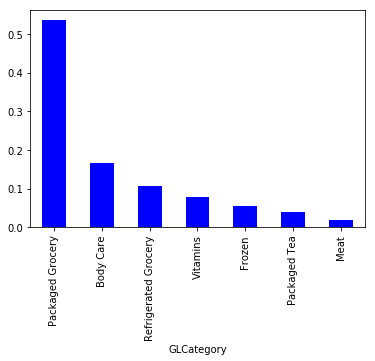

In [14]:
(training_df.groupby('GLCategory').size() / len(training_df)).sort_values(ascending=False).plot(kind='bar', color='blue');

In [15]:
(training_df.groupby('GLCategory').size() / len(training_df)).sort_values(ascending=False)

GLCategory
Packaged Grocery        0.535002
Body Care               0.166596
Refrigerated Grocery    0.106633
Vitamins                0.079621
Frozen                  0.054731
Packaged Tea            0.039457
Meat                    0.017961
dtype: float64

## Distributions

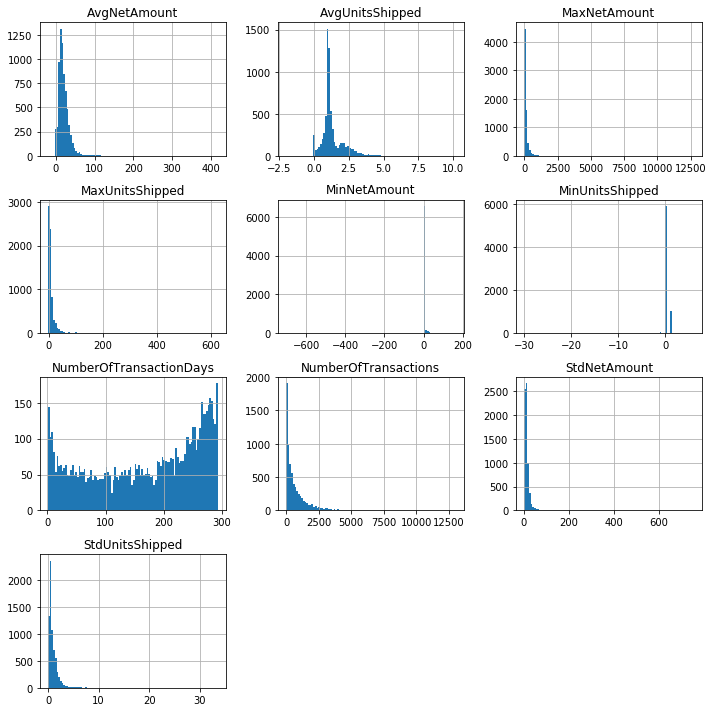

In [16]:
training_df.hist(figsize=(10,10), bins=100);
plt.tight_layout();

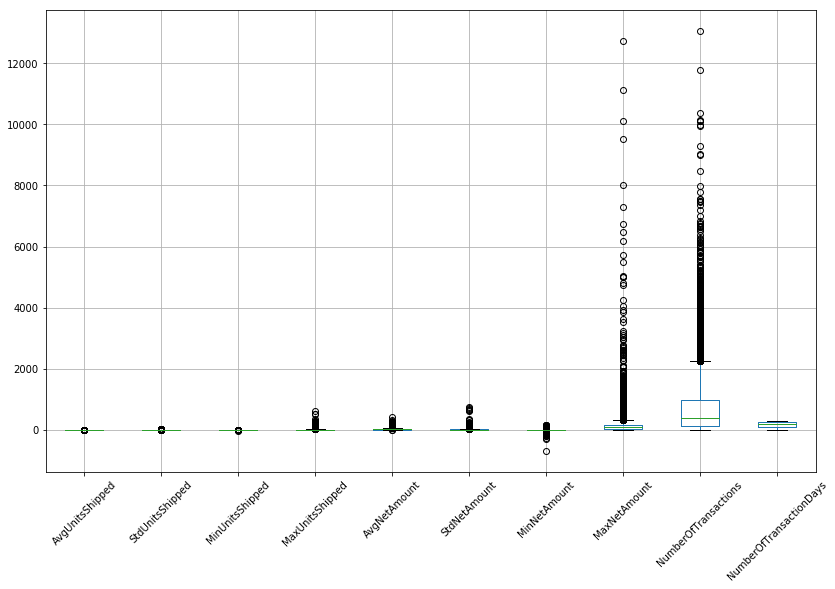

In [18]:
training_df.boxplot(figsize=(12,7));
plt.tight_layout();
plt.xticks(rotation=45);

Clearly some large outliers, in every dimension except for the number of days a product appeared. Outliers

In [19]:
training_df.describe()

,AvgUnitsShipped,StdUnitsShipped,MinUnitsShipped,MaxUnitsShipped,AvgNetAmount,StdNetAmount,MinNetAmount,MaxNetAmount,NumberOfTransactions,NumberOfTransactionDays
count,7071.000000,7008.000000,7071.000000,7071.000000,7071.000000,7008.000000,7071.000000,7071.000000,7071.000000,7071.000000
mean,1.317157,0.968692,0.116718,10.472635,20.959792,14.226758,0.539365,166.716736,751.402772,168.257814
std,0.857536,1.140811,0.715169,21.479026,19.262482,26.831354,15.581052,444.605398,1049.254809,93.404582
min,-2.000000,0.000000,-30.000000,-2.000000,-20.495000,0.000000,-702.000000,-18.000000,1.000000,1.000000
25%,0.952380,0.399606,0.000000,3.000000,11.016369,6.086789,0.000000,40.080000,117.000000,84.000000
50%,1.073891,0.627408,0.000000,6.000000,16.929151,9.458407,0.000000,77.940000,383.000000,188.000000
75%,1.435147,1.229189,0.000000,11.000000,26.226817,15.306873,0.000000,154.625000,967.500000,255.000000
max,10.181818,33.586118,6.000000,625.000000,418.480000,754.318156,163.620000,12733.750000,13045.000000,293.000000


* It seems odd that there would be products with **negative AvgUnitsShipped values**... Unless these were one-time returns.  This warrants a deeper analysis since it the negative values are likely to skew classifications, unless certain GL categories are associated with a larger number of returns.  There does not appear to be a lot of variation around UnitsShipped statistics except for MaxUnitsShipped.  Some products had instances of higher volume purchases compared to the norm.

* It appears that products are rather expensive with a AvgNetAmount value of \$21 and AvgUnitsShipped of 1.3 with the middle of the distribution laying between \$11 and \$26.  This means that, on average, NCG is paying $16/item (21 / 1.3).  **Were the enormously large values an anomaly or the due to increased volume for specific purchases?**

* The average product appeared on an invoice 751 times with a variance of +/- 1049 instances.  One product was included on an invoice as many as 13,000 times.

* On average, a product was purchased 168 days of the year which is roughly twice per year.  Most products were purchased between 84 and 255 times throughout 2017.

In [24]:
training_df.isnull().sum()

UniversalProductCode        0
AvgUnitsShipped             0
StdUnitsShipped            63
MinUnitsShipped             0
MaxUnitsShipped             0
AvgNetAmount                0
StdNetAmount               63
MinNetAmount                0
MaxNetAmount                0
NumberOfTransactions        0
NumberOfTransactionDays     0
GLCategory                  0
dtype: int64

Null standard deviation values are fine, they are the result of only a single record

In [25]:
training_df.groupby('GLCategory').apply(lambda x: x.StdUnitsShipped.isnull().sum()) / training_df.groupby('GLCategory').size()

GLCategory
Body Care               0.008489
Frozen                  0.005168
Meat                    0.000000
Packaged Grocery        0.006609
Packaged Tea            0.007168
Refrigerated Grocery    0.015915
Vitamins                0.021314
dtype: float64

## Exploratory Analysis

### Modelling sets
Create a test set before we do anything else so we don't bias the results

In [28]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
training = training_df.drop('UniversalProductCode', axis=1)
for train_index, test_index in split.split(training, training["GLCategory"]):
    strat_train_set = training.loc[train_index]
    strat_test_set = training.loc[test_index]

Make sure our proportions are right

In [29]:
original = training_df.groupby('GLCategory').size() / len(training_df)
train = strat_train_set.groupby('GLCategory').size() / len(strat_train_set)
test = strat_test_set.groupby('GLCategory').size() / len(strat_test_set)
print("Difference in training")
print("======================")
print(original - train)
print("Difference in test")
print("======================")
print(original - test)

Difference in training
GLCategory
Body Care               0.000047
Frozen                 -0.000078
Meat                   -0.000073
Packaged Grocery       -0.000005
Packaged Tea            0.000030
Refrigerated Grocery    0.000020
Vitamins                0.000059
dtype: float64
Difference in test
GLCategory
Body Care              -0.000188
Frozen                  0.000314
Meat                    0.000293
Packaged Grocery        0.000020
Packaged Tea           -0.000119
Refrigerated Grocery   -0.000081
Vitamins               -0.000238
dtype: float64


### Training set

In [30]:
categories = strat_train_set.copy()

In [31]:
(categories <= 0).sum().sort_index()

AvgNetAmount                165
AvgUnitsShipped             162
GLCategory                 5656
MaxNetAmount                163
MaxUnitsShipped             161
MinNetAmount               5143
MinUnitsShipped            4804
NumberOfTransactionDays       0
NumberOfTransactions          0
StdNetAmount                135
StdUnitsShipped             226
dtype: int64

It's weird that there are lines with zero units and zero dollars.

In [32]:
categories.query('AvgUnitsShipped == 0').head(10)

,AvgUnitsShipped,StdUnitsShipped,MinUnitsShipped,MaxUnitsShipped,AvgNetAmount,StdNetAmount,MinNetAmount,MaxNetAmount,NumberOfTransactions,NumberOfTransactionDays,GLCategory
5096,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,1,1,Packaged Grocery
1054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,4,Packaged Grocery
1580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4,Packaged Grocery
2463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,Packaged Grocery
2806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,7,Packaged Grocery
1128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4,Body Care
5174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59,43,Packaged Grocery
2319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,Frozen
1960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,Packaged Grocery
4724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,6,Packaged Grocery


Most zero-valued unit records are associated with other zero-valued metrics.  What does this look like accross GL categories?

In [33]:
categories[(categories.AvgUnitsShipped <= 0) | (categories.AvgNetAmount <= 0)].groupby('GLCategory').size().sort_values(ascending=False)

GLCategory
Packaged Grocery        93
Vitamins                19
Refrigerated Grocery    17
Body Care               16
Packaged Tea            11
Frozen                   9
dtype: int64

In [34]:
zero_totals = categories[(categories.AvgUnitsShipped <= 0) | (categories.AvgNetAmount <= 0)].groupby('GLCategory').size().sort_index()
totals = categories.groupby('GLCategory').size().sort_index()
(zero_totals / totals).sort_values(ascending=False)

GLCategory
Packaged Tea            0.049327
Vitamins                0.042222
Packaged Grocery        0.030734
Frozen                  0.029032
Refrigerated Grocery    0.028192
Body Care               0.016985
Meat                         NaN
dtype: float64

**It's not clear at this point how products with average net amount or units shipped values of 0 or less will skew the results.  It does however look like we will lose a non-negligable amount of training data if we drop the negative or zero-valued records.  We'll keep them in the set for now but we should keep an eye on correlation between errors and the number of zero/negative instances.**

### Multivariate Analysis

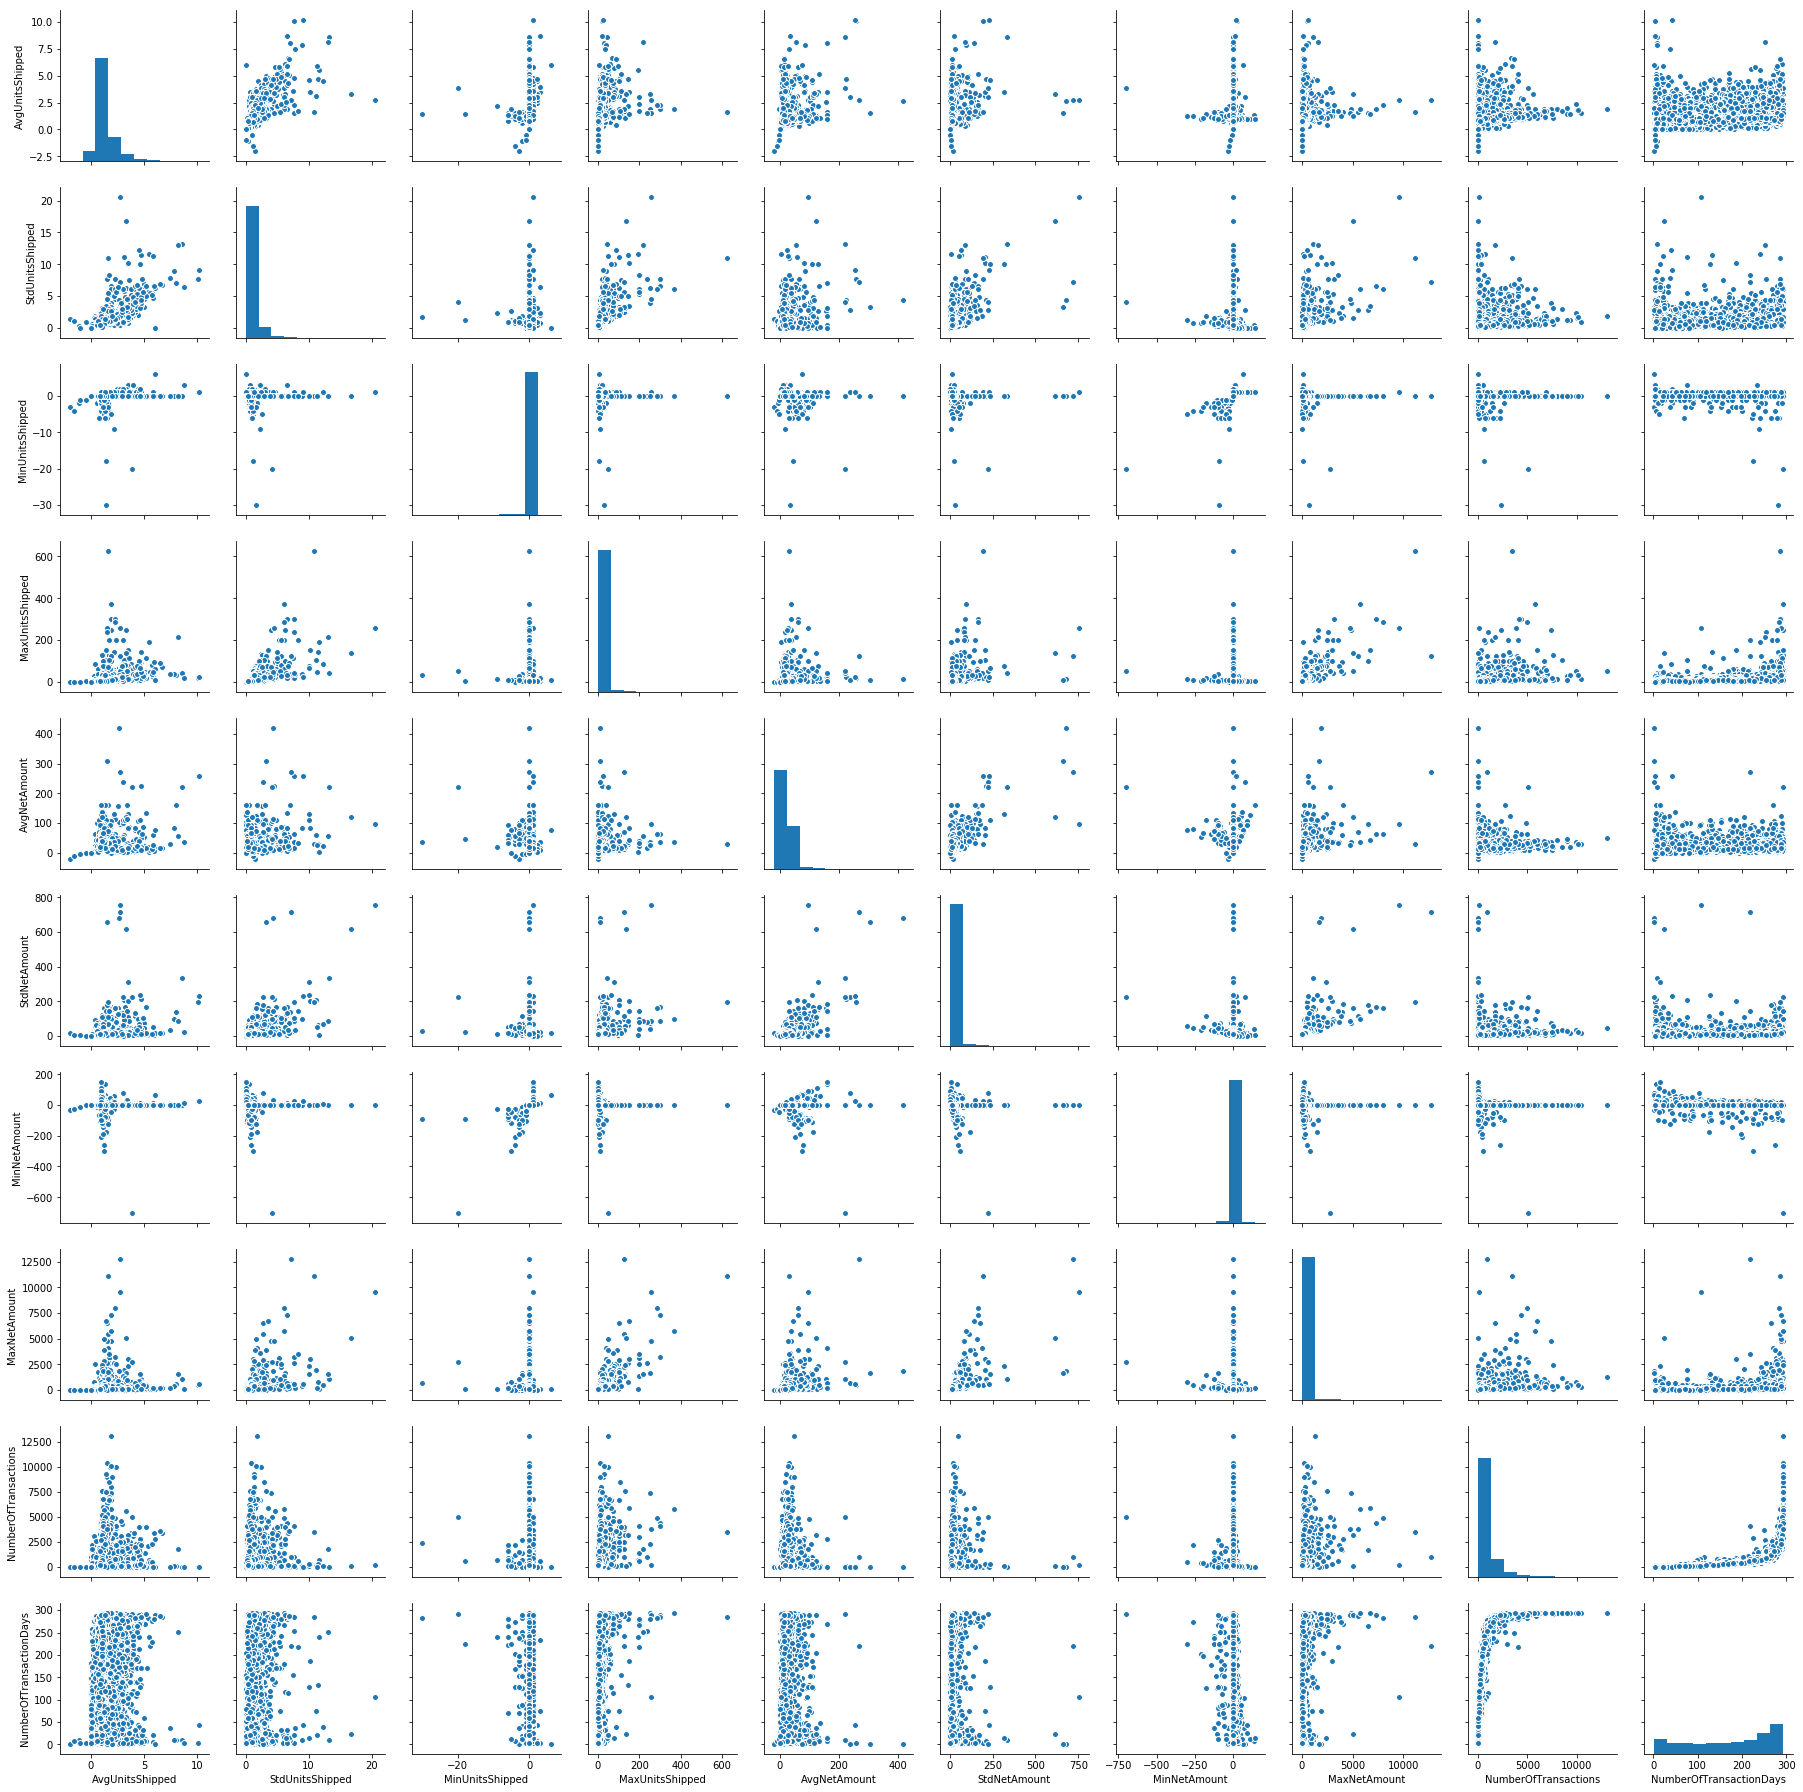

In [77]:
sns.pairplot(categories.dropna());

Look at correlations between numeric values

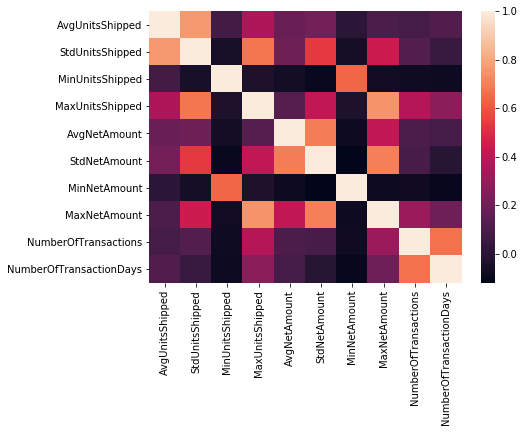

In [78]:
plt.figure(figsize=(7,5))
sns.heatmap(categories.drop('GLCategory', axis=1).corr());

Create a new feature 'TransactionsPerDay' that includes NumberOfTransactions and NumberOfTransactionDays

In [80]:
categories['TransactionsPerDay'] = categories['NumberOfTransactions'] / categories['NumberOfTransactionDays']
categories.corr()['TransactionsPerDay'].sort_values(ascending=False)

TransactionsPerDay         1.000000
NumberOfTransactions       0.988071
NumberOfTransactionDays    0.605595
MaxUnitsShipped            0.387799
MaxNetAmount               0.325110
StdUnitsShipped            0.154768
StdNetAmount               0.136890
AvgNetAmount               0.134393
AvgUnitsShipped            0.100019
MinNetAmount              -0.071238
MinUnitsShipped           -0.082252
Name: TransactionsPerDay, dtype: float64

**Moderate correlations exist among MaxUnitsUnitsShipped and MaxNetAmount.**

### Univariate Analysis

Plot the histograms of the variables

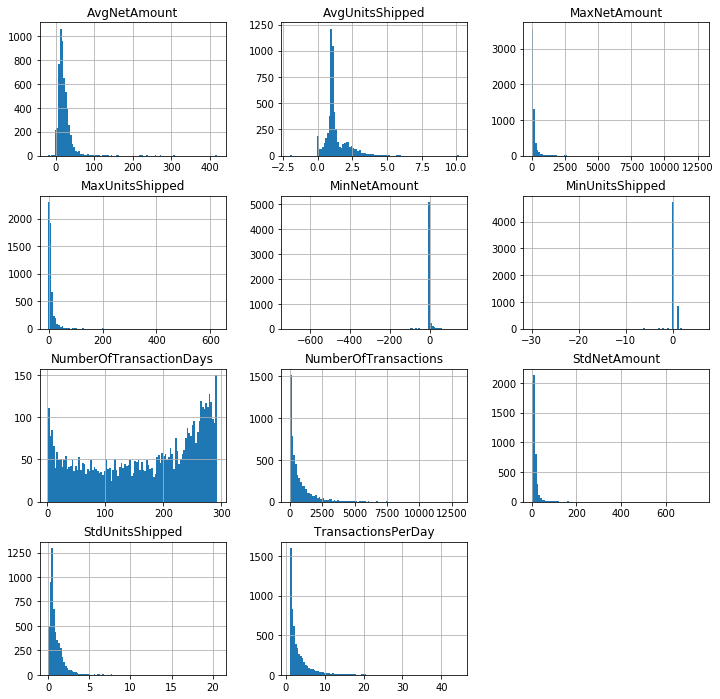

In [82]:
categories.drop(['GLCategory'], axis=1).hist(figsize=(12,12), bins=100);

It's clear from these histograms that there are some large outliers in the data and log transforms would likely work well to help mitigate them.  From the bi-modal NumberOfTransactionDays variable, it appears that there are products that are purchased very frequently and not very frequently.

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


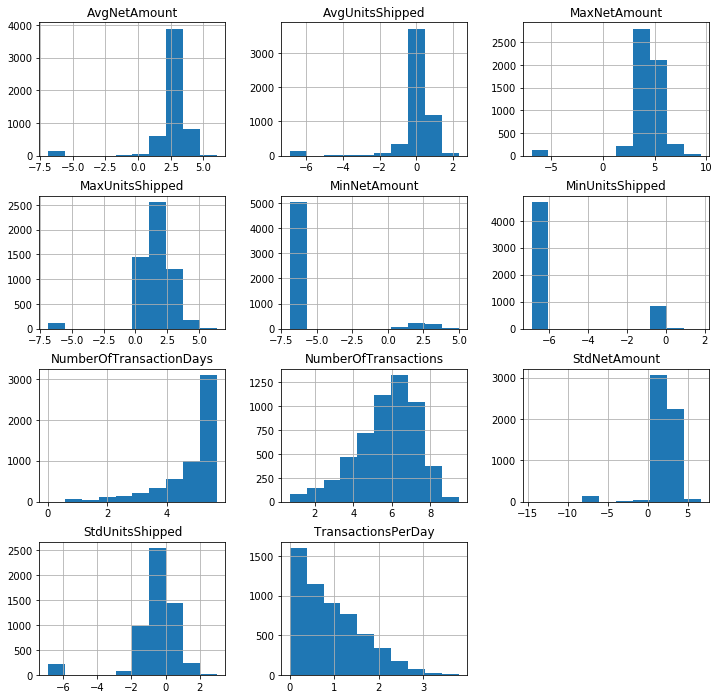

In [84]:
categories_log = categories.drop(['GLCategory'], axis=1).copy()
categories_log = categories_log.replace(to_replace=0, value=.001)
np.log(categories_log).dropna().hist(figsize=(12,12));

Are there strong signals in GL categories?

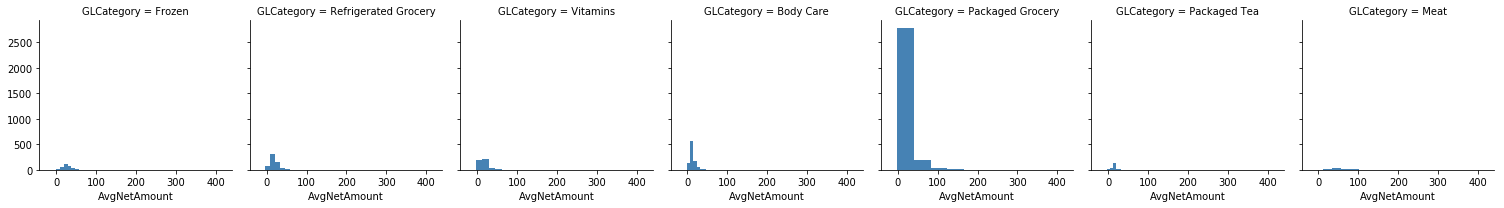

In [86]:
g = sns.FacetGrid(pd.concat([categories_log, categories.GLCategory], axis=1), col='GLCategory', margin_titles=True)
g.map(plt.hist, "AvgNetAmount", color="steelblue", lw=0);

Distributions look dissimilar, AvgNetAmount looks good

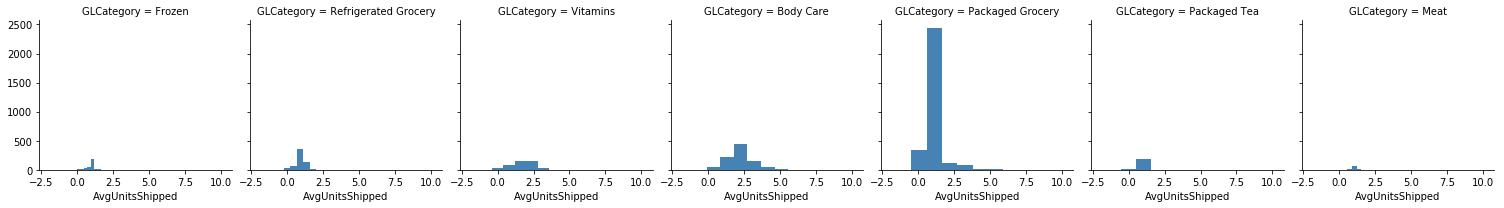

In [89]:
g = sns.FacetGrid(pd.concat([categories_log, categories.GLCategory], axis=1), col='GLCategory', margin_titles=True)
g.map(plt.hist, "AvgUnitsShipped", color="steelblue", lw=0);

Distributions look dissimilar, AvgUnitsShipped looks good

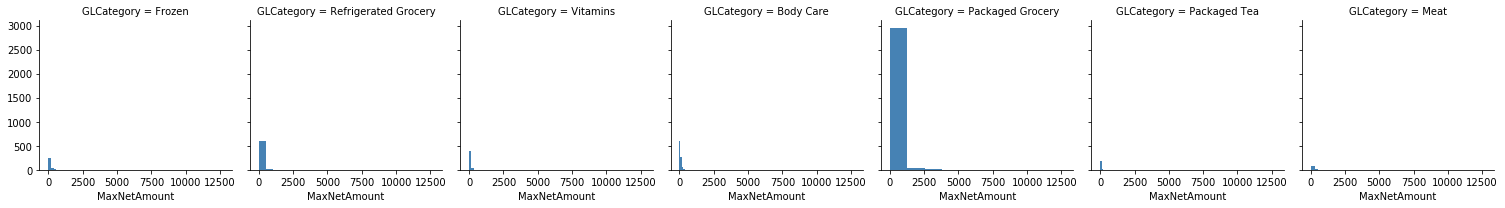

In [90]:
g = sns.FacetGrid(categories, col='GLCategory', margin_titles=True)
g.map(plt.hist, "MaxNetAmount", color="steelblue", lw=0);

Distributions look similar, MaxNetAmount might not be very informative

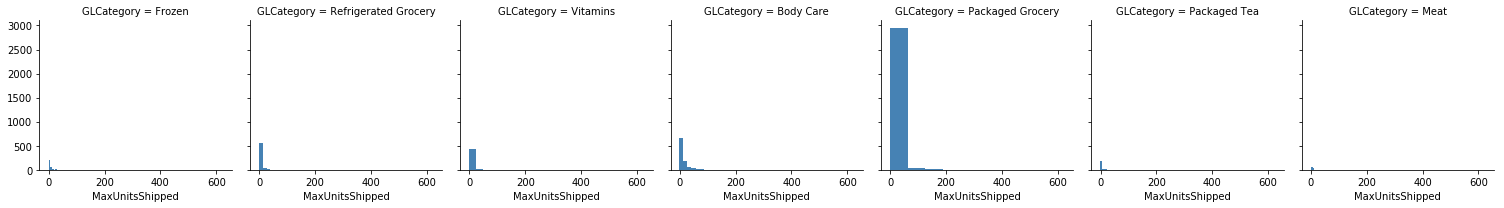

In [91]:
g = sns.FacetGrid(categories, col='GLCategory', margin_titles=True)
g.map(plt.hist, "MaxUnitsShipped", color="steelblue", lw=0);

Distributions look similar, MaxUnitsShipped might not be very informative

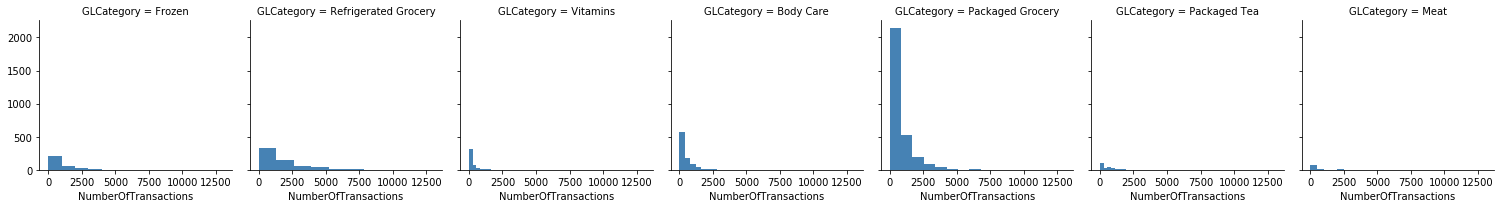

In [92]:
g = sns.FacetGrid(categories, col='GLCategory', margin_titles=True)
g.map(plt.hist, "NumberOfTransactions", color="steelblue", lw=0);

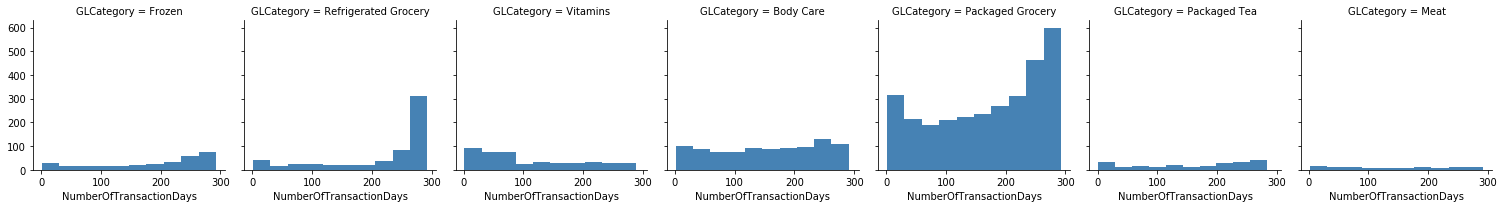

In [93]:
g = sns.FacetGrid(categories, col='GLCategory', margin_titles=True)
g.map(plt.hist, "NumberOfTransactionDays", color="steelblue", lw=0);

Number of transaction days looks very informative

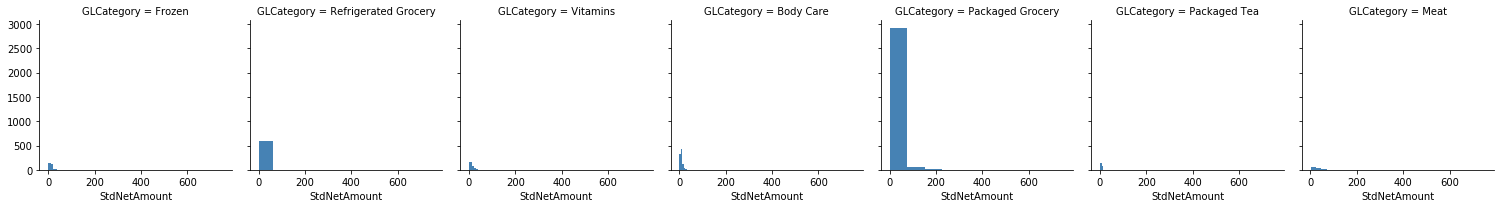

In [94]:
d = categories_log.merge(categories[['GLCategory']], how='inner', left_index=True, right_index=True)
g = sns.FacetGrid(d, col='GLCategory', margin_titles=True)
g.map(plt.hist, "StdNetAmount", color="steelblue", lw=0);

Log StdNetAmount looks like it might be informative.

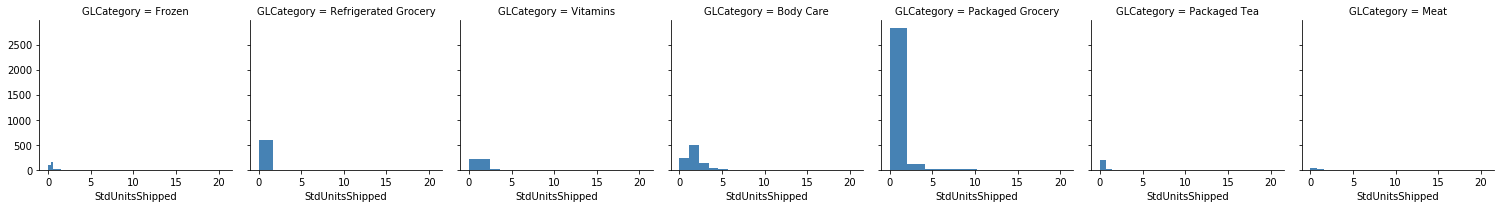

In [95]:
d = categories_log.merge(categories[['GLCategory']], how='inner', left_index=True, right_index=True)
g = sns.FacetGrid(d, col='GLCategory', margin_titles=True)
g.map(plt.hist, "StdUnitsShipped", color="steelblue", lw=0);

Log of StdUnitsShipped looks like it might be informative

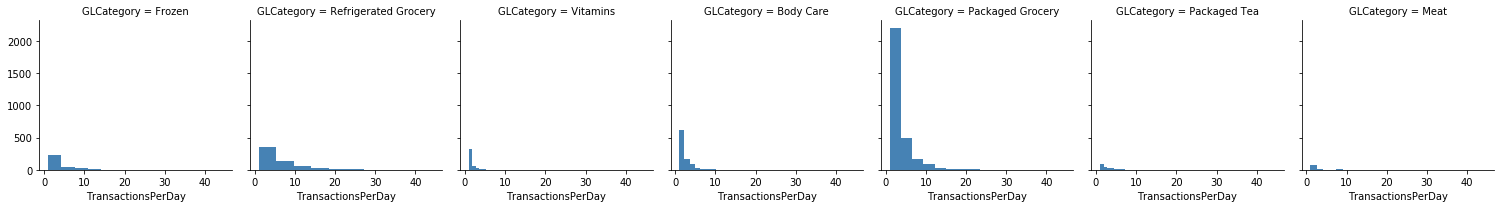

In [96]:
g = sns.FacetGrid(categories, col='GLCategory', margin_titles=True)
g.map(plt.hist, "TransactionsPerDay", color="steelblue", lw=0);

TransactionsPerDay looks informative

### Bivariate Analysis

Create a log transform since most variables would benefit from it.

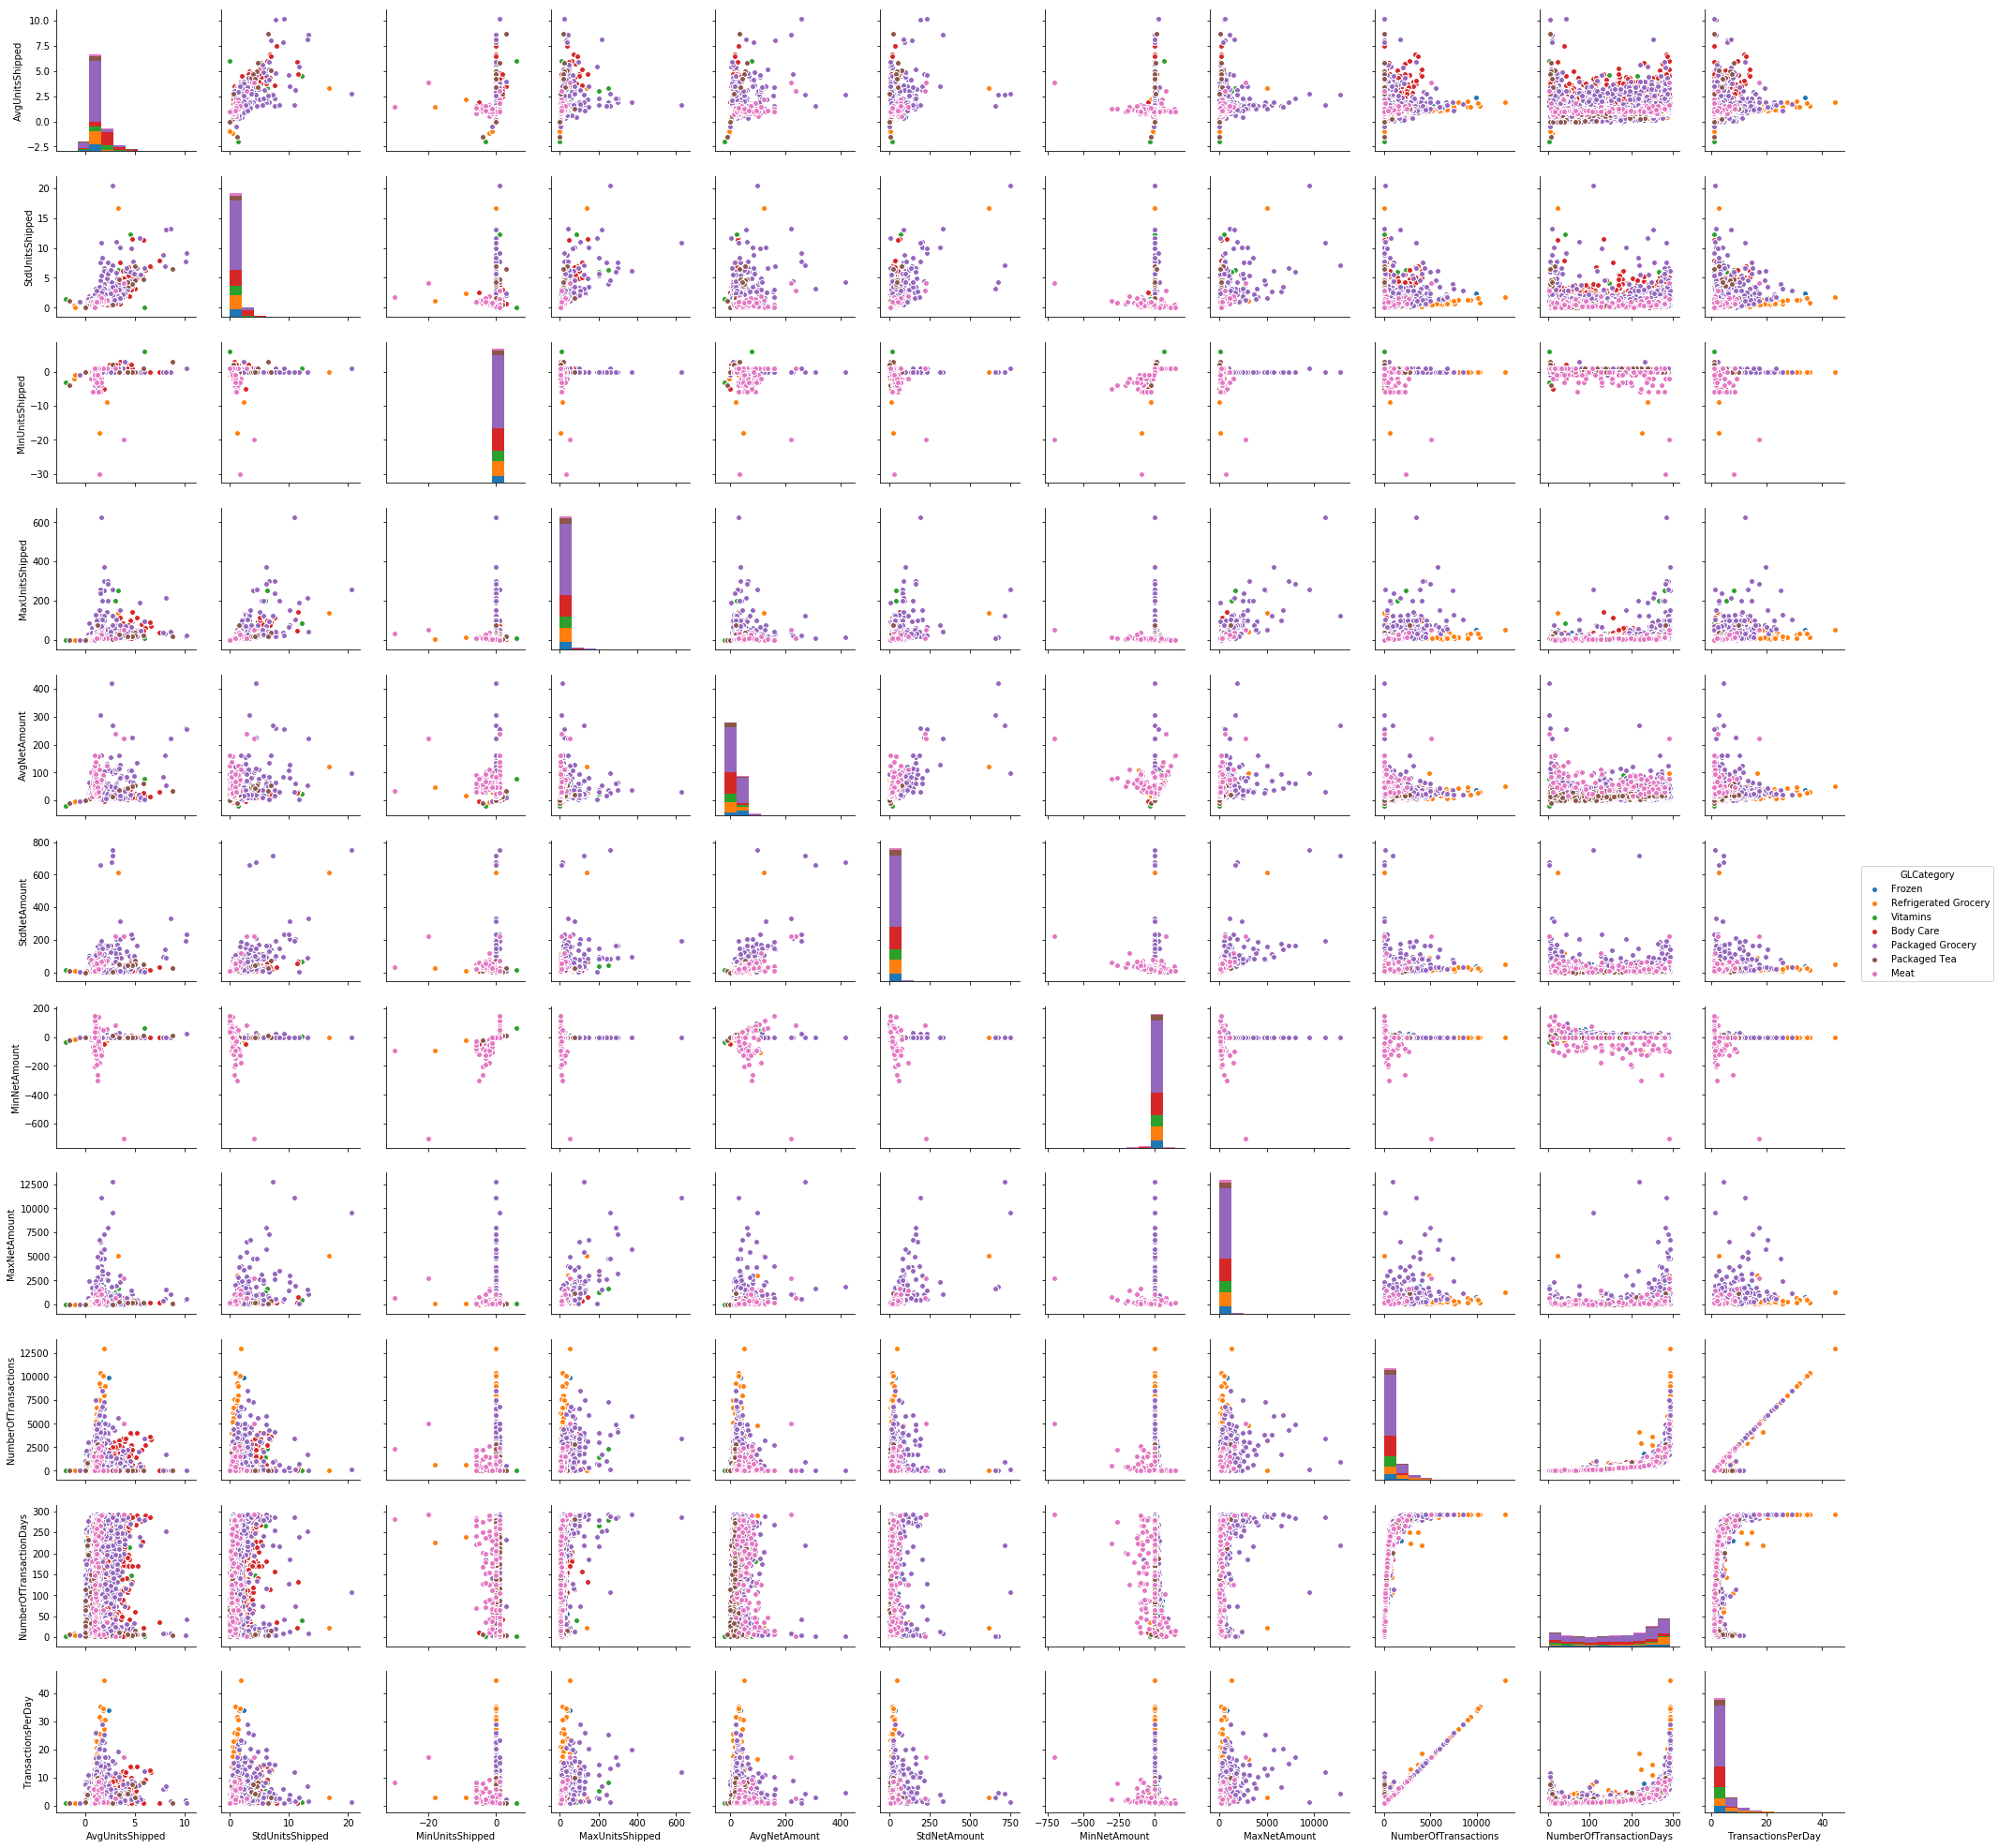

In [97]:
sns.pairplot(categories.dropna(), hue='GLCategory');

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


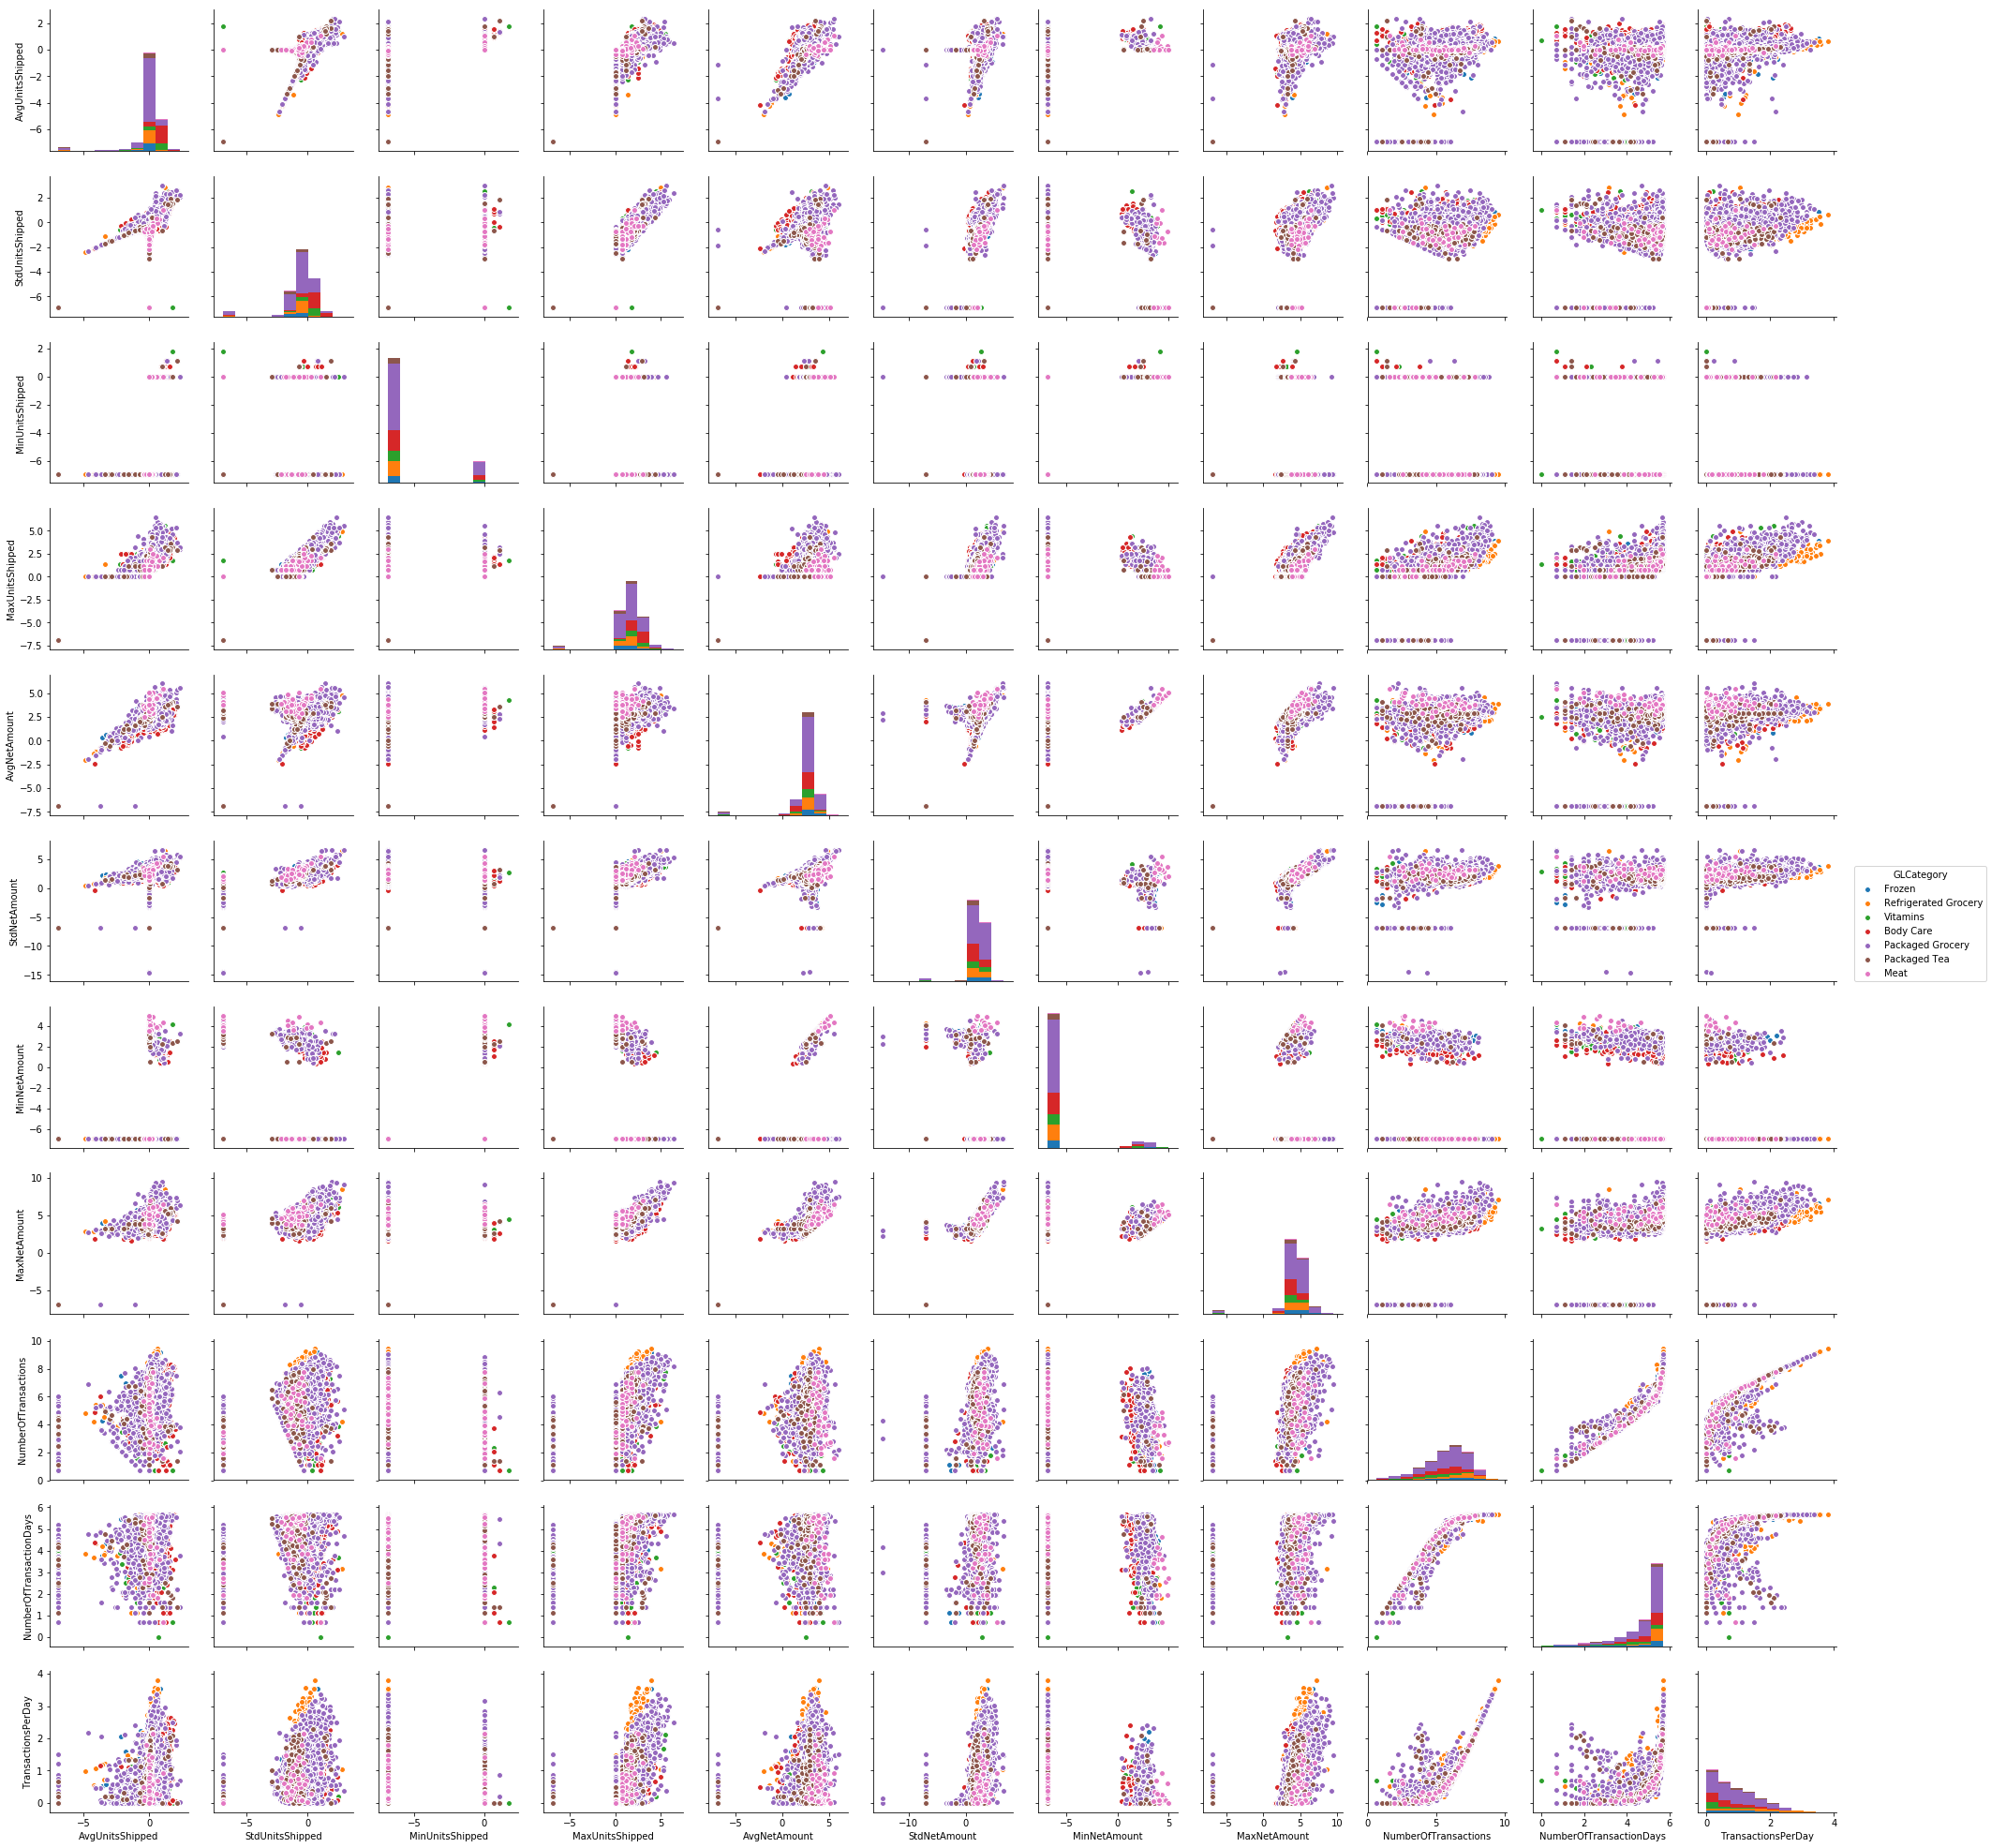

In [98]:
categories_log = categories.drop(['GLCategory'], axis=1)
categories_log = categories_log.replace(to_replace=0, value=.001)
categories_log = np.log(categories_log).dropna()

d = categories_log.merge(categories[['GLCategory']], how='inner', left_index=True, right_index=True)
sns.pairplot(d, hue='GLCategory');

The decision surface looks complex but classes look like they'll be seperable in higher dimensions.  SVMs and decision trees seem like they'd be good candidates here.

### Output

In [ ]:
strat_train_set.to_csv('../data/categories-train-2018-03-04.csv')
strat_test_set.to_csv('../data/categories-test-2018-03-04.csv')